# Melanoma Detection Assignment

Melanoma is the most serious type of skin cancer. It occurs when the pigment-producing cells that give colour to the skin become cancerous. Symptoms might include a new, unusual growth or a change in an existing mole. Melanomas can occur anywhere on the body. Though it is very fatal, it is curable in most cases if its detected in its early stages. Therefore having an automated, reliable, scalable system which can detect the disease by looking at the image is a life saver.

### Problem statement: 
Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Input: 
The input dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:
- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion


### Importing all the important libraries

In [2]:
# importing python libraries required for the analysis
import pathlib
import tensorflow as tf # for creating deep learning models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os #to read files from filesystem
import PIL
from tensorflow import keras #developing and evaluating deep learning models
from tensorflow.keras import layers #data-processing module
from tensorflow.keras.models import Sequential # to use Sequential model

### Data Reading & Understanding

In [14]:
# Reading the input data set - both test & train.
# Its assumed that all the input images are present in "Skin cancer ISIC The International Skin Imaging Collaboration" 
# folder. And this folder is present in one level above the directory as this source file present
#Also assumed that Train data set is present in Train folder and test in Test folder
train_data_dir = pathlib.Path("../Skin cancer ISIC The International Skin Imaging Collaboration/Train")
test_data_dir = pathlib.Path("../Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [15]:
#Understand the dataset
#Check the number of files present for Train & Test
image_count_train = len(list(train_data_dir.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(test_data_dir.glob('*/*.jpg')))
print(image_count_test)

2239
118


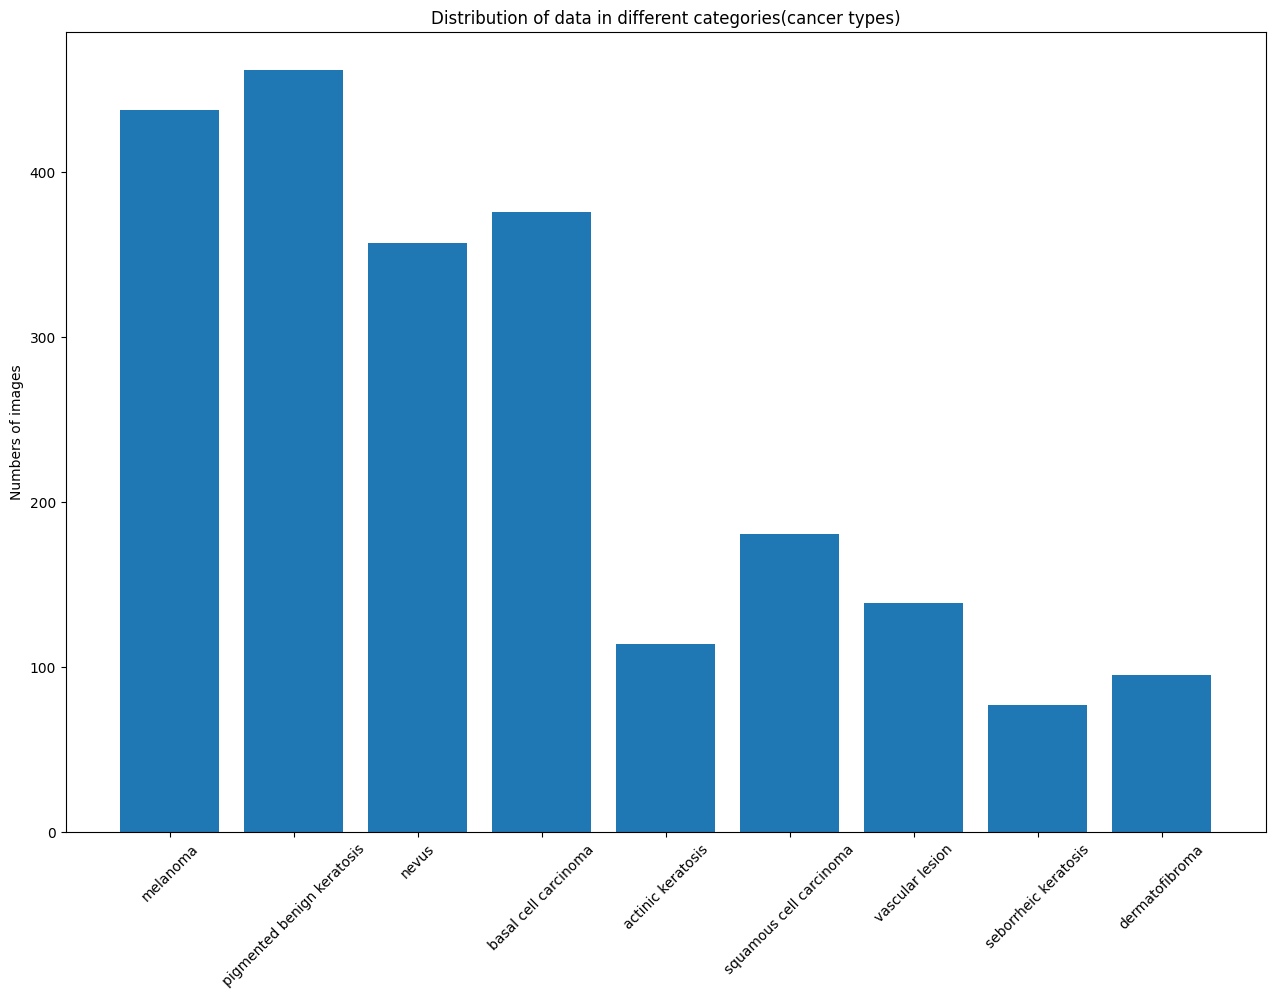

In [67]:
# Check the number of images under each category
x=[]
y=[]
#get file count in each directory
dirList = os.listdir(train_data_dir)
for i in range(len(dirList)):
  x.append(dirList[i])
  y.append(len(list(train_data_dir.glob(dirList[i]+'/*.jpg'))))


fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])

ax.bar(x,y)
ax.set_ylabel('Numbers of images')
ax.set_title('Distribution of data in different categories(cancer types)')
plt.xticks(rotation=45)
plt.show()

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Dataset Creation

Define some parameters for the loader:

In [34]:
batch_size = 32
img_height = 180
img_width = 180
seed_val = 123
input_shape=(img_height,img_width,3)

Use 80% of the images for training, and 20% for validation.

In [23]:
# Read the train dataset(80%) using seed=123 using keras preprocessing image_dataset_from_directory utility
# resizing images to the size img_height=180*img_width=180, while loading the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_data_dir,
                                                               seed=seed_val,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [24]:
# Read the validation dataset(20%) using seed=123 using keras preprocessing image_dataset_from_directory utility
# resizing images to the size img_height=180*img_width=180, while loading the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(train_data_dir,
                                                               seed=seed_val,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [25]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Dataset Visualisation

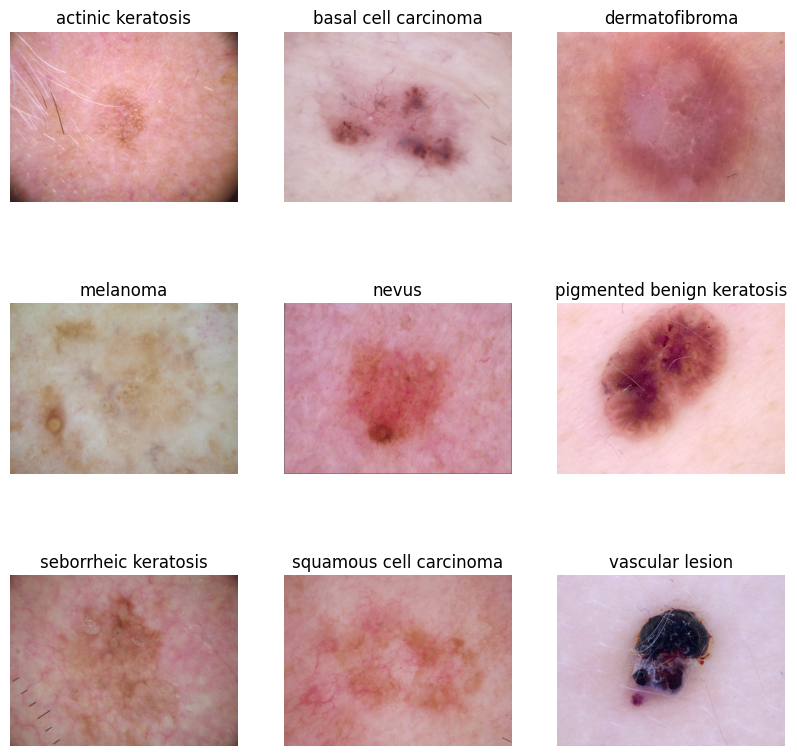

In [29]:
### visualize one image of all the nine classes present in the dataset
plt.figure(figsize=(10,10))
for i in range(len(class_names)): #loop through each class
  plt.subplot(3,3,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[0])) #pick the first image in each directory
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis("off") #scale doesn't make any relevance here

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension, '3', refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [30]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
Create a CNN model, which can accurately detect 9 classes present in the dataset. Use "layers.experimental.preprocessing.Rescaling" to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [57]:
model = Sequential() # allows stack of layers where each layer has exactly one input tensor and one output tensor

# rescale to 0-255 range; which is the range of RGB values
model.add(layers.Rescaling(scale=1./255,input_shape=input_shape))

#1st convulation layer in the stack
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2))) #pooling 1/2
model.add(layers.Dropout(0.25))#dropping 25%

#2nd convulation layer in the stack
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25)) #dropping 25%

#3rd convulation layer in the stack
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))#dropping 25%

# flatten takes all these and put it into a long flat vector. i.e put a fully connected layer
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu')) # create fully connected layers
model.add(layers.Dropout(0.25))#dropping 25%

# softmax layer
model.add(layers.Dense(len(class_names), activation='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [58]:
# View the summary of all layers
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 89, 89, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                 

### Train the model

In [59]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 35s 604ms/step - loss: 2.2882 - accuracy: 0.1657 - val_loss: 2.0861 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 43s 770ms/step - loss: 2.0324 - accuracy: 0.2003 - val_loss: 2.1099 - val_accuracy: 0.2931
Epoch 3/20
56/56 [==============================] - 39s 703ms/step - loss: 1.9624 - accuracy: 0.2840 - val_loss: 1.8981 - val_accuracy: 0.3669
Epoch 4/20
56/56 [==============================] - 44s 780ms/step - loss: 1.7135 - accuracy: 0.4046 - val_loss: 1.6261 - val_accuracy: 0.4698
Epoch 5/20
56/56 [==============================] - 41s 732ms/step - loss: 1.6091 - accuracy: 0.4247 - val_loss: 1.5859 - val_accuracy: 0.4698
Epoch 6/20
56/56 [==============================] - 41s 736ms/step - loss: 1.5293 - accuracy: 0.4727 - val_loss: 1.4789 - val_accuracy: 0.5078
Epoch 7/20
56/56 [==============================] - 42s 754ms/step - loss: 1.4833 - accuracy: 0.4771 - val_loss: 1.4688 - val_accuracy: 0.5324

### Visualizing training results

In [50]:
#Need to visualize the results at multiple places
#Hence creating a common method
def visualize_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('accuracy')
    plt.xlabel(epochs_range)
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='lower left')
    plt.ylabel('loss')
    plt.xlabel(epochs_range)    
    plt.title('Training and Validation Loss')
    plt.axis("on")
    plt.show()

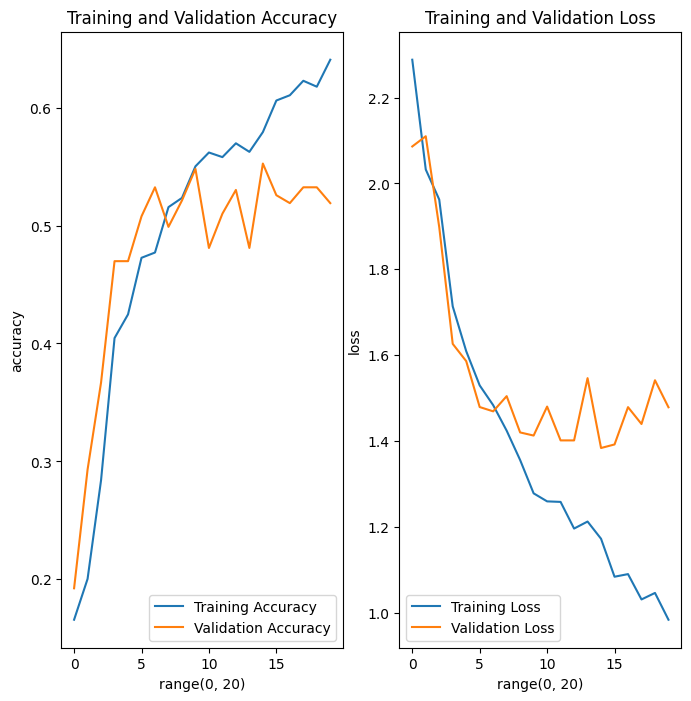

In [61]:
visualize_results(history)

In [84]:
t_loss, t_accuracy = model.evaluate(train_ds, verbose=1,)
v_loss, v_accuracy = model.evaluate(val_ds, verbose=1)

print("Training Accuracy: ", t_accuracy)
print("Validation Accuracy: ",v_accuracy)

print("Training Loss: ",t_loss)
print("Validation Loss", v_loss)

14/14 [==============================] - 2s 176ms/step - loss: 1.4518 - accuracy: 0.4720
Training Accuracy:  0.5239955186843872
Validation Accuracy:  0.47203579545021057
Training Loss:  1.3230783939361572
Validation Loss 1.451796531677246


### Observations

- Training accuracy is increasing with the range and the training loss is decreasing with range. In case of Validation accuracy its increasing with range, but after 8/9th epoch, its not increasing much, showing a some what flat trend at 50%. Similar trend is seen for validation loss as well.
- Accuracy overall is very low, performs poorly on the training data. Hence we can conclude that the model is underfitting
- Some of the reasons for underfitting are noise in data, high bias in model, not enough dataset, model is too simple etc
- In our case, looks like the model needs to be trained on more dataset

In [72]:
# Performing data augmentation to generate additional training data from existing images
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.2, fill_mode='reflect'),
    layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect'),
  ]
)

2023-07-15 09:38:07.371430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1792]
	 [[{{node Placeholder/_4}}]]
2023-07-15 09:38:07.372370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1792]
	 [[{{node Placeholder/_0}}]]


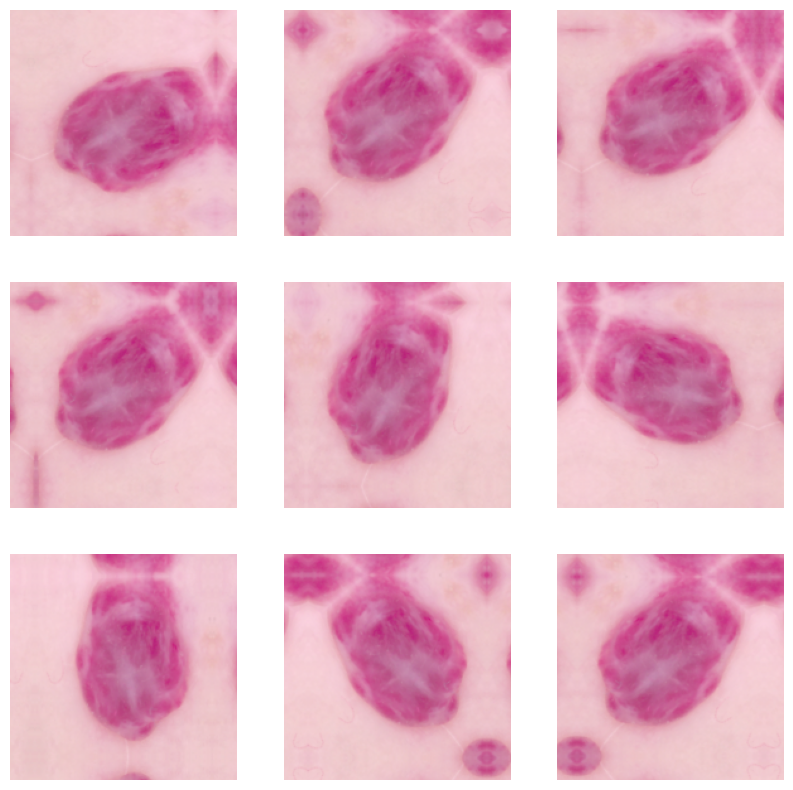

In [74]:
### visualize the augmented dataset
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
  for i in range(len(class_names)):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[1].numpy().astype("uint8"))
    plt.axis("off") #scale doesn't make any relevance here

### Create the model, compile and train the model


In [79]:
model = Sequential() # allows stack of layers where each layer has exactly one input tensor and one output tensor

# rescale to 0-255 range; which is the range of RGB values
model.add(layers.Rescaling(scale=1./255,input_shape=input_shape))

# adding the augmentation layer
model.add(data_augmentation)

#1st convulation layer in the stack
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2))) #pooling 1/2
model.add(layers.Dropout(0.25))#dropping 25%

#2nd convulation layer in the stack
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25)) #dropping 25%

#3rd convulation layer in the stack
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))#dropping 25%

#4th convulation layer in the stack
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))#dropping 25%

# flatten takes all these and put it into a long flat vector. i.e put a fully connected layer
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu')) # create fully connected layers
model.add(layers.Dropout(0.25))#dropping 25%

# softmax layer
model.add(layers.Dense(len(class_names), activation='softmax'))



### Compiling the model

In [80]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
# View the summary of all layers
model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 sequential_11 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 89, 89, 32)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 87, 87, 64)        18496     
                                                     

### Training the model

In [81]:
#train the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 40s 699ms/step - loss: 2.0957 - accuracy: 0.1908 - val_loss: 2.0961 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 40s 723ms/step - loss: 2.0329 - accuracy: 0.1998 - val_loss: 2.0323 - val_accuracy: 0.3266
Epoch 3/20
56/56 [==============================] - 52s 936ms/step - loss: 1.8547 - accuracy: 0.3192 - val_loss: 1.7146 - val_accuracy: 0.4251
Epoch 4/20
56/56 [==============================] - 45s 806ms/step - loss: 1.7417 - accuracy: 0.3666 - val_loss: 1.8093 - val_accuracy: 0.3579
Epoch 5/20
56/56 [==============================] - 46s 830ms/step - loss: 1.6713 - accuracy: 0.4023 - val_loss: 1.6046 - val_accuracy: 0.4340
Epoch 6/20
56/56 [==============================] - 51s 914ms/step - loss: 1.5731 - accuracy: 0.4386 - val_loss: 1.5352 - val_accuracy: 0.4586
Epoch 7/20
56/56 [==============================] - 49s 871ms/step - loss: 1.5222 - accuracy: 0.4542 - val_loss: 1.5534 - val_accuracy: 0.4452

### Visualizing the results

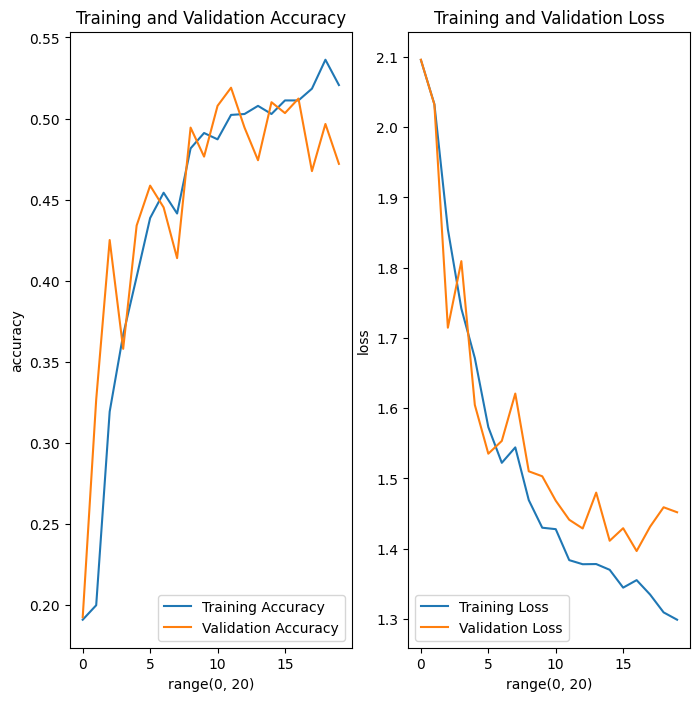

In [82]:
visualize_results(history)

In [83]:
t_loss, t_accuracy = model.evaluate(train_ds, verbose=1,)
v_loss, v_accuracy = model.evaluate(val_ds, verbose=1)

print("Training Accuracy: ", t_accuracy)
print("Validation Accuracy: ",v_accuracy)

print("Training Loss: ",t_loss)
print("Validation Loss", v_loss)

14/14 [==============================] - 3s 178ms/step - loss: 1.4518 - accuracy: 0.4720
Training Accuracy:  0.5239955186843872
Validation Accuracy:  0.47203579545021057
Training Loss:  1.3230788707733154
Validation Loss 1.451796531677246


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

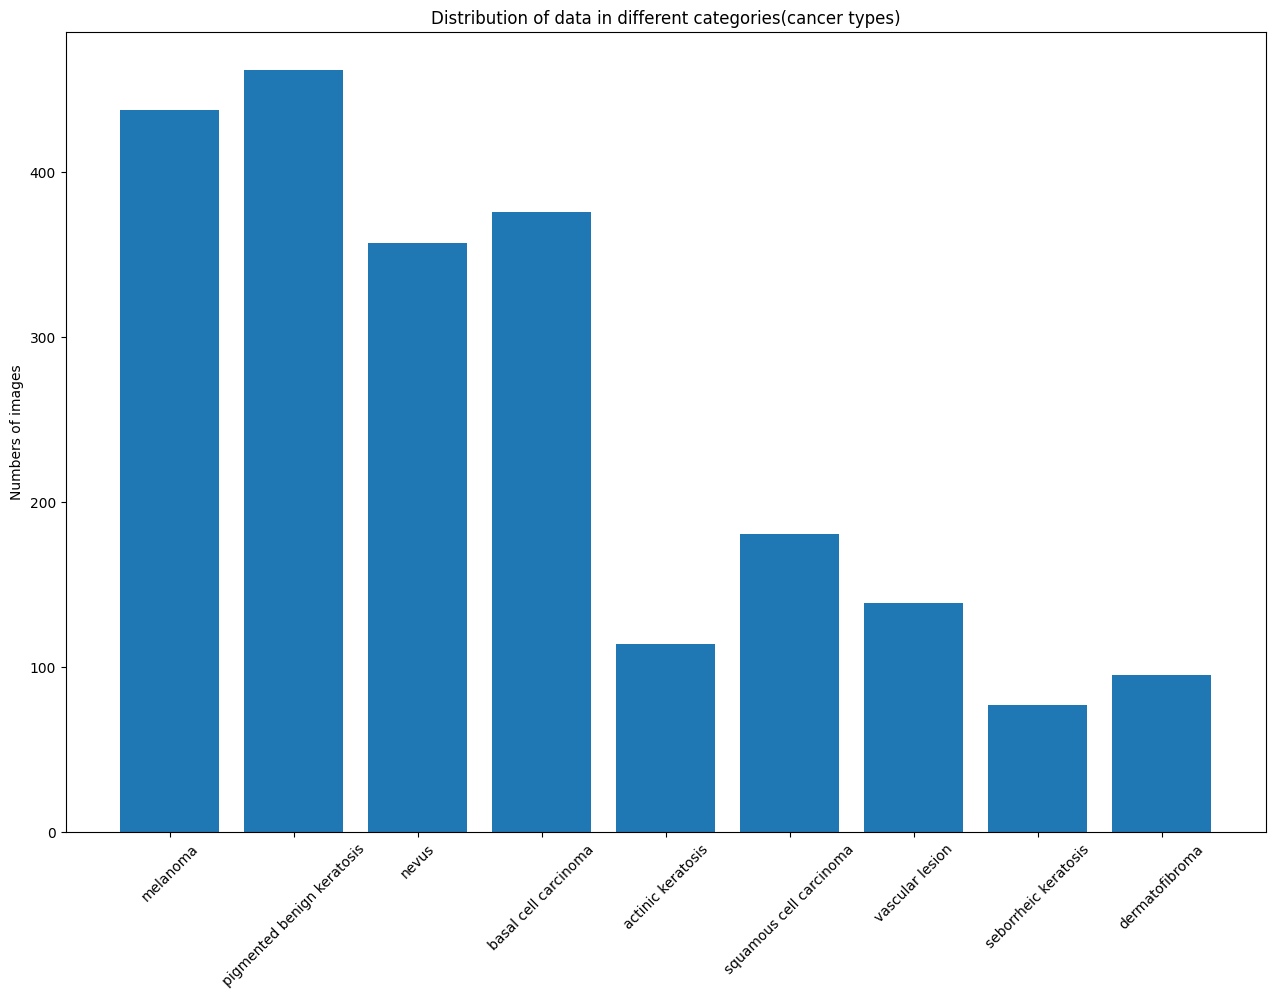

In [86]:
#Visualize the data distribution over different categories
x=[]
y=[]
#get file count in each directory
dirList = os.listdir(train_data_dir)
for i in range(len(dirList)):
  x.append(dirList[i])
  y.append(len(list(train_data_dir.glob(dirList[i]+'/*.jpg'))))


fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])

ax.bar(x,y)
ax.set_ylabel('Numbers of images')
ax.set_title('Distribution of data in different categories(cancer types)')
plt.xticks(rotation=45)
plt.show()

#### Observations
    The number of images present for each category vary widely from . This shows imbalence in dataset.
- Which class has the least number of samples? 
     "seborrheic keratosis"
- Which classes dominate the data in terms proportionate number of samples?
    "pigmented benign keratosis"


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="To do"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here

#### **Todo:**  Train your model

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
history = # your model fit code

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

